In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate


In [227]:
pathdata = '/home/daniu/Documentos/fundar/indice-mercado-trabajo-ingresos/'
pathdata = '/home/daniufundar/Documents/Fundar/indice-mercado-trabajo-ingresos/'
pathdata = '/Users/danielarisaro/Documents/fundar/indice-mercado-trabajo-ingresos/'


df_people_2016 = pd.read_csv(pathdata + 'data_input/personas_tot_urb_3T_16.txt', delimiter=';', low_memory=False)
df_people_2017 = pd.read_csv(pathdata + 'data_input/personas_tot_urb_3T_17.txt', delimiter=';', low_memory=False)
df_people_2018 = pd.read_csv(pathdata + 'data_input/personas_tot_urb_3T_18.txt', delimiter=';', low_memory=False)
df_people_2019 = pd.read_csv(pathdata + 'data_input/personas_tot_urb_3T_19.txt', delimiter=';', low_memory=False)
df_people_2020 = pd.read_csv(pathdata + 'data_input/personas_tot_urb_3T_20.txt', delimiter=';', low_memory=False)
df_people_2021 = pd.read_csv(pathdata + 'data_input/personas_tot_urb_3T_21.txt', delimiter=';', low_memory=False)
df_people_2022 = pd.read_csv(pathdata + 'data_input/personas_tot_urb_3T_22.txt', delimiter=';', low_memory=False)

In [251]:
import numpy as np
import pandas as pd

def generate_table(df_people):
    # Calculate total population
    pob = df_people['PONDERA'].sum()

    # Calculate number of observations
    cantidad_observaciones = len(df_people)

    # Calculate number of surveys performed
    encuesta_realizada = df_people[df_people['H15'] == 1]['H15'].count()
    pob_encuesta_realizada = df_people[df_people['H15'] == 1]['PONDERA'].sum()

    # Calculate number of imputed surveys
    encuesta_imputada = df_people[df_people['IMPUTA']==1]['IMPUTA'].count()
    pob_encuesta_imputada = df_people[df_people['IMPUTA'] == 1]['PONDERA'].sum()

    # Create the table as a pandas dataframe
    data = {'Parameter': ['Population', 'Number of Observations', 'Number of Surveys Performed', 'Population of Surveys Performed', 'Number of Imputed Surveys', 'Population of Imputed Surveys'],
            'Value': [pob, cantidad_observaciones, encuesta_realizada, pob_encuesta_realizada, encuesta_imputada, pob_encuesta_imputada]}
    table = pd.DataFrame(data)
    table.set_index('Parameter', inplace=True)
    
    return table


In [253]:
# Initialize an empty list to store the tables
tables = []

# Loop through the years
for year in range(16, 23):
    # Load the data for the year
    data_file = pathdata + f"data_input/personas_tot_urb_3T_{year}.txt"
    df_people = pd.read_csv(data_file, delimiter=';', low_memory=False)
    
    # Generate the table for the year
    table = generate_table(df_people)
    
    # Add the table to the list with the year as the key
    tables.append((str(year), table))

# Concatenate the tables horizontally
concatenated_df = pd.concat(dict(tables), axis=1)


<AxesSubplot:>

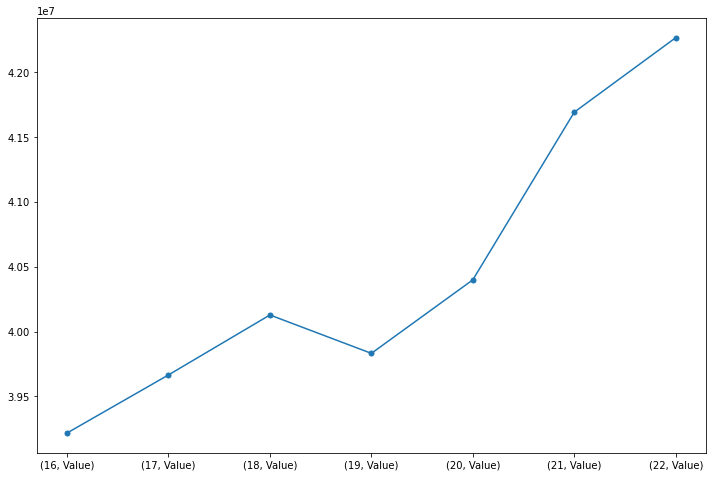

In [277]:
plt.figure(figsize=(12,8))
concatenated_df.loc['Population'].plot(marker='.', markersize=10)


In [254]:
concatenated_df

,16,17,18,19,20,21,22
,Value,Value,Value,Value,Value,Value,Value
Parameter,,,,,,,
Population,39218146,39666414,40128882,39832799,40399992,41693498,42268056
Number of Observations,95782,93891,90807,88949,63162,78217,77642
Number of Surveys Performed,81134,79818,77090,75708,54458,67764,67418
Population of Surveys Performed,33241721,33722644,34186673,34073501,34019917,35320840,36015455
Number of Imputed Surveys,192,144,116,96,56,110,109
Population of Imputed Surveys,151628,145052,124367,96049,92684,210549,142860


In [278]:
merged_df = pd.merge(df_people_2021[['CODUSU', 'COMPONENTE']], df_people_2022[['CODUSU', 'COMPONENTE']], on=['CODUSU', 'COMPONENTE'], how='outer', indicator=True)

# Count the number of duplicate rows
duplicated_rows = merged_df['_merge'].value_counts()['both']
print(f"Number of duplicate rows: {duplicated_rows}")

# Display the left-only rows
left_only_rows = merged_df['_merge'].value_counts()['left_only']
print(f"Left-only rows: {left_only_rows}")

# Display the right-only rows
right_only_rows = merged_df['_merge'].value_counts()['right_only']
print(f"Right-only rows: {right_only_rows}")

# Select the right-only rows from merged_df
right_only_rows = merged_df[merged_df['_merge'] == 'right_only']
left_only_rows = merged_df[merged_df['_merge'] == 'left_only']
both_rows = merged_df[merged_df['_merge'] == 'both']
left_both_rows = pd.concat([both_rows, right_only_rows])

# Unir los dataframes usando merge
df_people_2021_no_dupl = pd.merge(right_only_rows, df_people_2021, on=["CODUSU", "COMPONENTE"], how='inner')
df_people_2022_no_dupl = pd.merge(left_both_rows, df_people_2022, on=["CODUSU", "COMPONENTE"], how='inner')

# Drop duplicates
#df_people_2021_no_dupl = df_people_2021_no_dupl.drop_duplicates()
#df_people_2022_no_dupl = df_people_2022_no_dupl.drop_duplicates()

Number of duplicate rows: 30417
Left-only rows: 48100
Right-only rows: 47523


In [279]:
right_only_rows

,CODUSU,COMPONENTE,_merge
78517,TQRMNOQYYHJKKQCDEIIAD00785582,1,right_only
78518,TQRMNOQYYHJKKQCDEIIAD00785582,6,right_only
78519,TQRMNOTPPHJKKQCDEIIAD00785333,3,right_only
78520,TQRMNOTPXHJKKQCDEIIAD00785338,3,right_only
78521,TQRMNOQXPHJKLLCDEIIAD00791267,1,right_only
...,...,...,...
126035,TQRMNOSTWHKLKUCDELHIH00658895,4,right_only
126036,TQRMNOSTWHKLKUCDELHIH00658895,3,right_only
126037,TQRMNOSTWHKLKUCDELHIH00658895,1,right_only
126038,TQRMNOTVYHKLLPCDEKMHB00657981,3,right_only


In [280]:
# PONDERA DIST
df_people_2020_no_dupl['PONDERA'].describe()

count   39374.00
mean      731.22
std      1582.51
min        17.00
25%       151.00
50%       271.00
75%       579.00
max     37442.00
Name: PONDERA, dtype: float64

In [110]:
# Income 2021
income_dist_2021 = df_people_2021_no_dupl[['CH04','P47T','PONDII','PONDERA']].copy()
income_dist_2021['Weighted Income'] = (df_people_2021_no_dupl['P47T']*df_people_2021_no_dupl['PONDII'])


In [120]:
sorted_income_dist_2021 = income_dist_2021[income_dist_2021['P47T']!=-9].sort_values(by='P47T',ascending=True).dropna()

In [125]:
sorted_income_dist_2021['Weighted Income'].sum()

890154645499.0

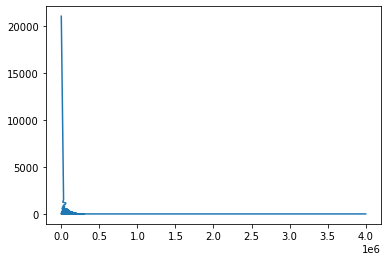

In [136]:
sorted_income_dist_2021['P47T','PONDII'].value_counts().sort_values()

In [138]:
income_dist_2021

,CH04,P47T,PONDII,PONDERA,Weighted Income
0,2,-9.00,0,995,-0.00
1,2,0.00,2615,2615,0.00
2,2,0.00,1340,1340,0.00
3,2,0.00,1127,1127,0.00
4,2,40000.00,1320,913,52800000.00
...,...,...,...,...,...
54945,1,50000.00,527,496,26350000.00
54946,1,150000.00,483,455,72450000.00
54947,2,50000.00,465,455,23250000.00
54948,1,-9.00,0,494,-0.00


In [133]:
sorted_income_dist_2021['P47T'].describe()
iqr = 39000.00 - 0.00
mediana = 14800.00
valor_sup = mediana + 2*iqr
print(valor_sup)

92800.0


In [134]:
sorted_income_dist_2021['P47T'].describe()


count     50121.00
mean      26125.37
std       46462.56
min           0.00
25%           0.00
50%       14800.00
75%       39000.00
max     4000000.00
Name: P47T, dtype: float64

In [149]:
sorted_income_dist_2021['rel Weighted Income'] = sorted_income_dist_2021['Weighted Income']/np.nansum(sorted_income_dist_2021['Weighted Income'])
sorted_income_dist_2021['rel Pob'] = sorted_income_dist_2021['PONDII']/np.nansum(sorted_income_dist_2021['PONDII'])
sorted_income_dist_2021.tail(40)

,CH04,P47T,PONDII,PONDERA,Weighted Income,rel Weighted Income,rel Pob
23812,2,400000.00,1248,1235,499200000.00,0.00,0.00
33579,2,400000.00,333,317,133200000.00,0.00,0.00
52009,1,400000.00,582,539,232800000.00,0.00,0.00
53724,1,400000.00,2461,2221,984400000.00,0.00,0.00
49176,1,400000.00,1074,747,429600000.00,0.00,0.00
21863,1,400000.00,2749,2042,1099600000.00,0.00,0.00
21440,2,408000.00,1946,1372,793968000.00,0.00,0.00
29379,1,420000.00,200,199,84000000.00,0.00,0.00
19338,1,430000.00,114,115,49020000.00,0.00,0.00
20531,2,440000.00,2499,1006,1099560000.00,0.00,0.00


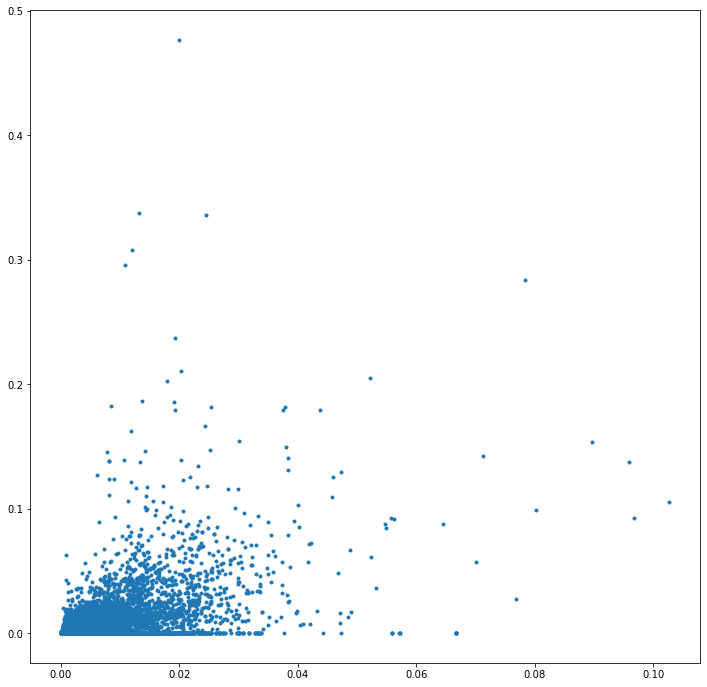

In [146]:
plt.figure(figsize=(12, 12))
plt.plot(sorted_income_dist_2021['rel Pob']*100, sorted_income_dist_2021['rel Weighted Income']*100,'.')

In [150]:
sorted_income_dist_2021_grouped = sorted_income_dist_2021.groupby('P47T', as_index=False).agg({'PONDII': 'sum'})

sorted_income_dist_2021_grouped

,P47T,PONDII
0,0.00,12393773
1,250.00,597
2,300.00,6420
3,400.00,42
4,500.00,3925
...,...,...
1105,1268000.00,143
1106,1500000.00,253
1107,2003500.00,279
1108,3017000.00,1


In [161]:
sorted_income_dist_2021_grouped['P47T'].describe()

count      1110.00
mean      83179.86
std      194496.68
min           0.00
25%       21203.25
50%       40150.00
75%       82575.00
max     4000000.00
Name: P47T, dtype: float64

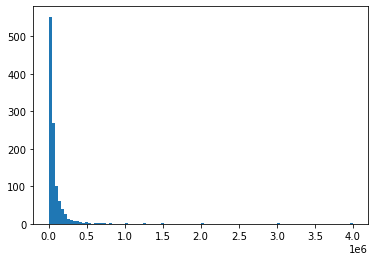

In [162]:
plt.hist(sorted_income_dist_2021_grouped['P47T'], bins=100);

Text(0, 0.5, 'Freq')

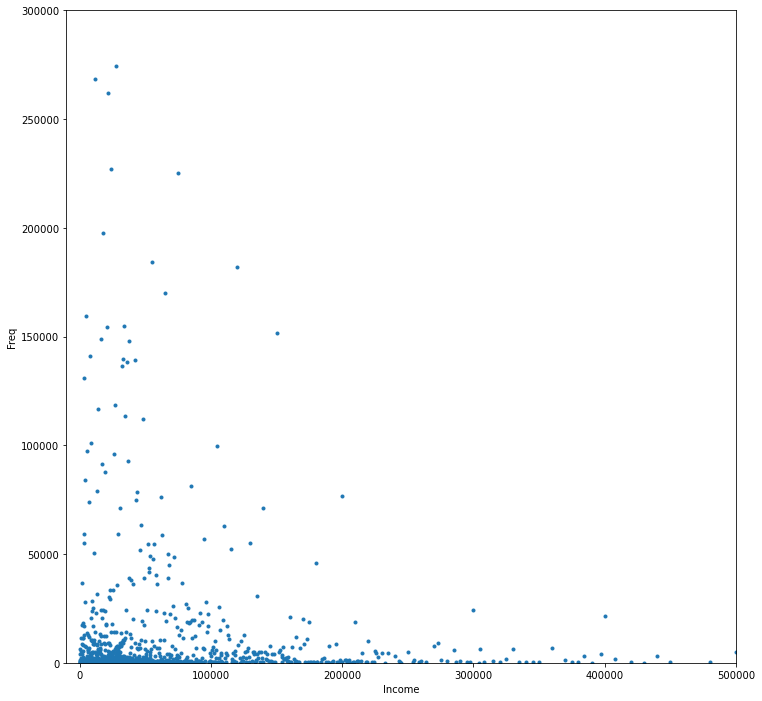

In [156]:
plt.figure(figsize=(12, 12))
plt.plot(sorted_income_dist_2021_grouped['P47T'],sorted_income_dist_2021_grouped['PONDII'],'.')
plt.xlim([-10000, 500000])
plt.ylim([0,300000])
plt.xlabel('Income')
plt.ylabel('Freq')


In [111]:
income_dist_2021

,CH04,P47T,PONDII,PONDERA,Weighted Income
0,2,-9.00,0,995,-0.00
1,2,0.00,2615,2615,0.00
2,2,0.00,1340,1340,0.00
3,2,0.00,1127,1127,0.00
4,2,40000.00,1320,913,52800000.00
...,...,...,...,...,...
54945,1,50000.00,527,496,26350000.00
54946,1,150000.00,483,455,72450000.00
54947,2,50000.00,465,455,23250000.00
54948,1,-9.00,0,494,-0.00


In [93]:
# Income 2021
income_dist_2021 = df_people_2021_no_dupl[['CH04','P47T','PONDII','PONDERA']].copy()
income_dist_2021['Weighted Income'] = (df_people_2021_no_dupl['P47T']*df_people_2021_no_dupl['PONDII'])/df_people_2021_no_dupl['PONDII'].sum()


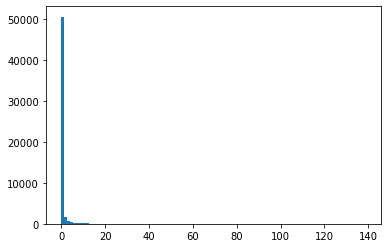

In [100]:
plt.hist(income_dist_2021['Weighted Income'], bins=100);